In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import plotly.express as px
import xarray as xr
from pandas.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D
import os
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import Normalize
import xgboost as xgb
from sklearn.linear_model import LinearRegression
import shap
from sklearn.ensemble import RandomForestRegressor
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import itertools
import cftime
import re
import imageio
from skimage.transform import resize

C:\Users\benra\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
# Cell 2: Data Loading and Preparation
netcdf_dir = r"C:\Users\benra\lithk_expa03"
netcdf_files = [os.path.join(netcdf_dir, f) for f in os.listdir(netcdf_dir) if f.endswith('.nc')]

deltas = []
participating_models = []
var_list = []

exp_id = 'expa03'  # Next few lines need to be changed for different datasets
var_name = 'lithk'

n_components = 4
n_clusters = 5  # Change this for expc02 (most likely other tiered experiments too)

# Define the standardization function
def standardize_model_name(model_name_from_netcdf):
    """
    Transforms a model name from the NetCDF derived format
    to match the 'Model ID' format in the characteristics CSV.
    """
    # Specific rules for ILTS_PIK_SICOPOLIS models
    if model_name_from_netcdf == 'ILTS_PIK_SICOPOLIS1':
        return 'ILTSPIK- SICOPOLIS1'
    elif model_name_from_netcdf == 'ILTS_PIK_SICOPOLIS2':
        return 'ILTSPIK- SICOPOLIS2'
    
    # General rule: for all other models, replace underscores with dashes
    return model_name_from_netcdf.replace('_', '-')

print("--- Starting Model Name Extraction and Standardization ---")
print(f"Checking directory: {netcdf_dir}")
print(f"Found {len(netcdf_files)} .nc files.")

# This loop iterates through EACH AND EVERY NetCDF file found
for i, file_path in enumerate(netcdf_files):
    print(f"\nProcessing file {i+1}/{len(netcdf_files)}: {os.path.basename(file_path)}")
    
    base_filename = os.path.basename(file_path)
    
    # --- Step 1: Extract the raw model name from the filename ---
    # This part gets the name like 'ILTS_PIK_SICOPOLIS2' or 'IMAU_IMAUICE1'
    model_id_raw = base_filename.replace('.nc', '')
    model_id_raw = model_id_raw.replace('lithk_GIS_', '')
    
    if model_id_raw.endswith('_expa03'):                      # Need to change this line for each experiment
        model_id_raw = model_id_raw.replace('_expa03', '')
    
    # Use regex to remove trailing '_<digits>' (like '_05')
    # This targets an underscore followed by one or more digits at the end of the string.
    model_id_raw = re.sub(r'_\d+$', '', model_id_raw)
        
    print(f"  Raw model name extracted (from NetCDF filename): '{model_id_raw}'")

    # --- Step 2: Call the standardization function for THIS specific raw model name ---
    # This line passes the 'model_id_raw' from the current file to the function.
    # The function then returns the standardized name.
    standardized_model_id = standardize_model_name(model_id_raw)
    
    print(f"  Standardized model name (for matching CSV): '{standardized_model_id}'")
    
    # --- Step 3: Add the standardized name to your list ---
    # This list will be used in Cell 6.
    participating_models.append(standardized_model_id)

    # --- Data loading (your existing xarray code) ---
    try:
        ds = xr.open_dataset(file_path, decode_times=False)
        var_dataarray = ds['lithk'] # Get the 'lithk' DataArray
        var_list.append(var_dataarray) # Add it to var_list
        ds.close() # Close the dataset to free up memory
    except Exception as e:
        print(f"  Error loading or processing NetCDF file '{base_filename}': {e}")
        # Consider adding a placeholder to var_list if a file fails,
        # or removing the corresponding model from participating_models,
        # to keep lists aligned. For now, it will just skip.

print("\n--- Finished Model Name Extraction and Standardization ---")
print(f"Total NetCDF files processed: {len(netcdf_files)}")
print(f"Final count of participating models in the list: {len(participating_models)}")
print("List of standardized participating models (ready for Cell 6):")
print(participating_models)

print(f"Total data arrays loaded into var_list: {len(var_list)}")

print("\nFinished initial data loading. Proceed to the next cell for PCA and plotting.")

--- Starting Model Name Extraction and Standardization ---
Checking directory: C:\Users\benra\lithk_expa03
Found 15 .nc files.

Processing file 1/15: lithk_GIS_AWI_ISSM1_expa03.nc
  Raw model name extracted (from NetCDF filename): 'AWI_ISSM1'
  Standardized model name (for matching CSV): 'AWI-ISSM1'

Processing file 2/15: lithk_GIS_AWI_ISSM2_expa03.nc
  Raw model name extracted (from NetCDF filename): 'AWI_ISSM2'
  Standardized model name (for matching CSV): 'AWI-ISSM2'

Processing file 3/15: lithk_GIS_AWI_ISSM3_expa03.nc
  Raw model name extracted (from NetCDF filename): 'AWI_ISSM3'
  Standardized model name (for matching CSV): 'AWI-ISSM3'

Processing file 4/15: lithk_GIS_BGC_BISICLES_expa03.nc
  Raw model name extracted (from NetCDF filename): 'BGC_BISICLES'
  Standardized model name (for matching CSV): 'BGC-BISICLES'

Processing file 5/15: lithk_GIS_GSFC_ISSM_expa03.nc
  Raw model name extracted (from NetCDF filename): 'GSFC_ISSM'
  Standardized model name (for matching CSV): 'GSFC-

In [3]:
# Assuming these variables are defined from your previous cells
# exp_id = 'your_experiment_id'
# var_name = 'lithk'

# Define the base directory where your basin outlier CSVs are saved
basin_outliers_dir = os.path.join("Research_Plots", f"{exp_id}_{var_name}_plots", "Basin_Outliers")

all_outliers_df = pd.DataFrame()

# Loop through all files in the Basin_Outliers directory
for filename in os.listdir(basin_outliers_dir):
    if filename.endswith(".csv"):
        filepath = os.path.join(basin_outliers_dir, filename)
        
        try:
            df = pd.read_csv(filepath)
            all_outliers_df = pd.concat([all_outliers_df, df], ignore_index=True)
        except Exception as e:
            print(f"Error reading {filename}: {e}")

print(f"Consolidated data for {len(all_outliers_df)} outlier entries.")
# Display the first few rows to verify
print(all_outliers_df.head())

Consolidated data for 200 outlier entries.
    Timestep  Basin_ID Outlier_Model_1 Outlier_Model_2 Outlier_Model_3
0  2015-2025        10       AWI-ISSM1       UAF-PISM1       UAF-PISM2
1  2015-2035        10    BGC-BISICLES       UAF-PISM1       UAF-PISM2
2  2015-2045        10    BGC-BISICLES       UAF-PISM1       UAF-PISM2
3  2015-2055        10    BGC-BISICLES       UAF-PISM1       UAF-PISM2
4  2015-2065        10    BGC-BISICLES       UAF-PISM1       UAF-PISM2


In [4]:
# Count occurrences of each model in the outlier columns
outlier_counts = pd.concat([
    all_outliers_df['Outlier_Model_1'],
    all_outliers_df['Outlier_Model_2'],
    all_outliers_df['Outlier_Model_3']
]).value_counts().sort_values(ascending=False)

print("\nOverall Outlier Frequency Across All Basins and Timesteps:")
print(outlier_counts)


Overall Outlier Frequency Across All Basins and Timesteps:
UAF-PISM1       200
UAF-PISM2       196
UCIJPL-ISSM1    104
BGC-BISICLES     47
AWI-ISSM1        24
AWI-ISSM2        11
AWI-ISSM3        10
VUB-GISM          5
LSCE-GRISLI       2
GSFC-ISSM         1
Name: count, dtype: int64


In [5]:
# Group by timestep and count occurrences
outlier_by_timestep = all_outliers_df.groupby('Timestep').apply(lambda x: pd.concat([x['Outlier_Model_1'], x['Outlier_Model_2'], x['Outlier_Model_3']]).value_counts())

print("\nOutlier Frequency by Timestep:")
print(outlier_by_timestep.fillna(0).astype(int)) # Fill NaNs with 0 for models not present in a timestep


Outlier Frequency by Timestep:
Timestep               
2015-2025  UAF-PISM1       25
           UAF-PISM2       25
           UCIJPL-ISSM1    13
           BGC-BISICLES     6
           AWI-ISSM1        4
                           ..
2015-2100  AWI-ISSM1        4
           LSCE-GRISLI      2
           AWI-ISSM3        1
           GSFC-ISSM        1
           AWI-ISSM2        1
Name: count, Length: 63, dtype: int32


In [6]:
# Group by basin and count occurrences
outlier_by_basin = all_outliers_df.groupby('Basin_ID').apply(lambda x: pd.concat([x['Outlier_Model_1'], x['Outlier_Model_2'], x['Outlier_Model_3']]).value_counts())

print("\nOutlier Frequency by Basin:")
print(outlier_by_basin.fillna(0).astype(int))


Outlier Frequency by Basin:
Basin_ID              
1         BGC-BISICLES    8
          UAF-PISM1       8
          UAF-PISM2       8
2         UCIJPL-ISSM1    8
          UAF-PISM2       8
                         ..
24        UAF-PISM2       8
25        UAF-PISM1       8
          UAF-PISM2       8
          AWI-ISSM3       4
          AWI-ISSM2       4
Name: count, Length: 87, dtype: int32


In [7]:
# Example for a specific model (replace 'Model_X' with an actual model name)
specific_model = 'VUW-PISM' # Example, replace with a model from your data
model_outlier_profile = all_outliers_df[
    (all_outliers_df['Outlier_Model_1'] == specific_model) |
    (all_outliers_df['Outlier_Model_2'] == specific_model) |
    (all_outliers_df['Outlier_Model_3'] == specific_model)
][['Timestep', 'Basin_ID']]

print(f"\nOutlier Profile for {specific_model}:")
print(model_outlier_profile)


Outlier Profile for VUW-PISM:
Empty DataFrame
Columns: [Timestep, Basin_ID]
Index: []


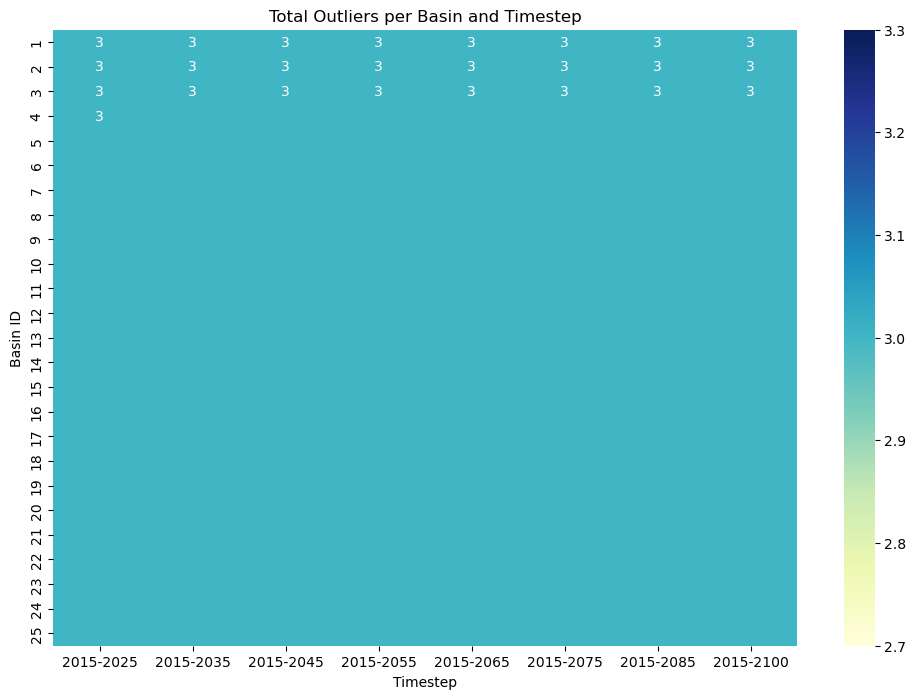

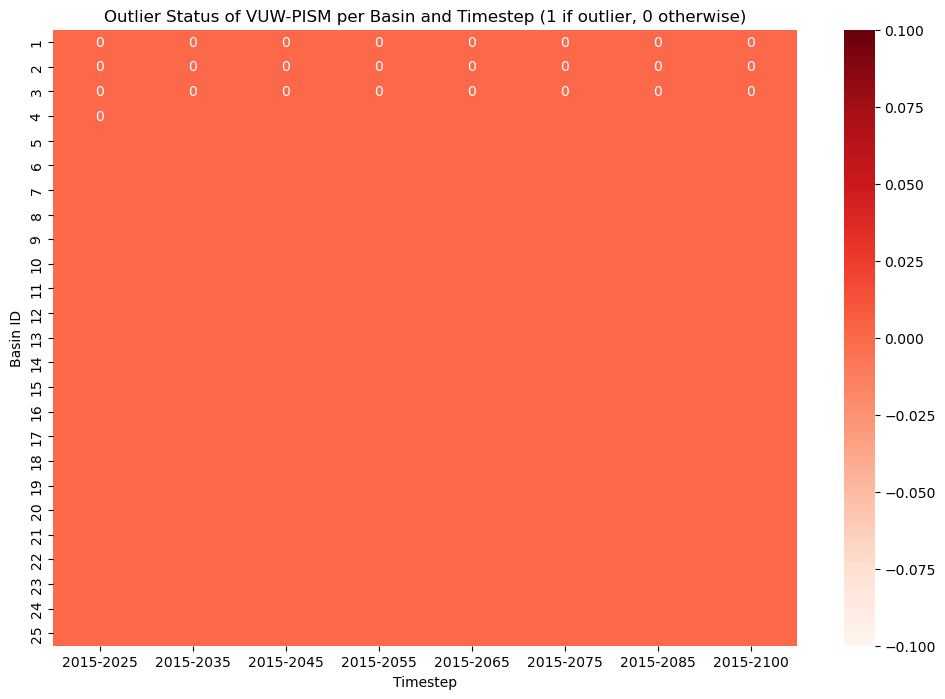

In [8]:
# Heatmap of total outliers per Basin and Timestep
# First, create a count of how many outliers each row contains
all_outliers_df['Outlier_Count'] = all_outliers_df[['Outlier_Model_1', 'Outlier_Model_2', 'Outlier_Model_3']].count(axis=1)

# Pivot table to get counts per basin and timestep
pivot_table = all_outliers_df.pivot_table(index='Basin_ID', columns='Timestep', values='Outlier_Count', aggfunc='sum')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table.fillna(0), annot=True, cmap="YlGnBu", fmt='g')
plt.title('Total Outliers per Basin and Timestep')
plt.xlabel('Timestep')
plt.ylabel('Basin ID')
plt.show()

# Example: Heatmap of a specific model's outlier status
# Create a boolean column for whether 'Model_X' is an outlier in a row
model_of_interest = 'VUW-PISM' # Replace
all_outliers_df[f'{model_of_interest}_is_Outlier'] = (
    (all_outliers_df['Outlier_Model_1'] == model_of_interest) |
    (all_outliers_df['Outlier_Model_2'] == model_of_interest) |
    (all_outliers_df['Outlier_Model_3'] == model_of_interest)
).astype(int) # Convert boolean to 0/1 for summation

pivot_model_outlier = all_outliers_df.pivot_table(
    index='Basin_ID', 
    columns='Timestep', 
    values=f'{model_of_interest}_is_Outlier', 
    aggfunc='sum'
)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_model_outlier.fillna(0), annot=True, cmap="Reds", fmt='g')
plt.title(f'Outlier Status of {model_of_interest} per Basin and Timestep (1 if outlier, 0 otherwise)')
plt.xlabel('Timestep')
plt.ylabel('Basin ID')
plt.show()

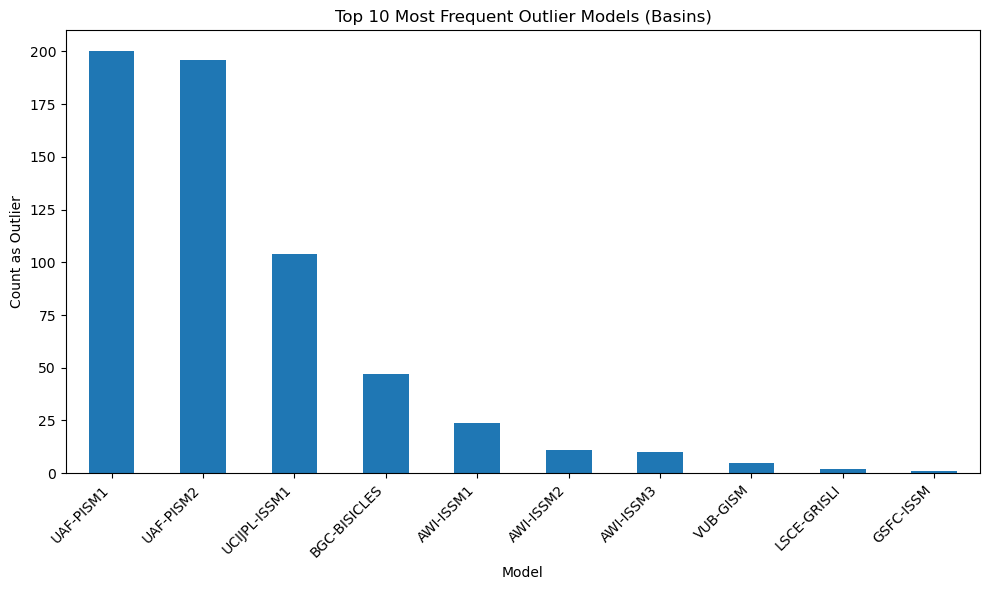

In [9]:
base_output_dir = os.path.join("Research_Plots", f"{exp_id}_{var_name}_plots")

plt.figure(figsize=(10, 6))
outlier_counts.head(10).plot(kind='bar') # Top 10 most frequent outliers
plt.title('Top 10 Most Frequent Outlier Models (Basins)')
plt.xlabel('Model')
plt.ylabel('Count as Outlier')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
bar_graph_filename = os.path.join(base_output_dir, f"{var_name}_{exp_id}_Basin_Outlier_Freq_Bar_Graph")
plt.savefig(bar_graph_filename, dpi=300)
plt.show()